# Final Experiment (Pain Level Classification)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.model_selection import KFold
from sklearn.utils import compute_class_weight
from sklearn.metrics import balanced_accuracy_score
from tensorflow.keras.models import load_model
from pathlib import Path

import sys
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.load_dataset import load_dataset, load_fusioned_dataset, get_class_names
from src.lib.time_series_augmentation.utils.augmentation import jitter, rotation
from src.models.CNNLSTM import CNNLSTM
from src.models.CNNLSTMfusioned import CNNLSTM_fusioned
from src.models.RCNN import RCNN
from src.models.RCNNfusioned import RCNN_fusioned
from src.lib.DeepStack.deepstack.base import KerasMember
from src.lib.DeepStack.deepstack.ensemble import DirichletEnsemble

In [2]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
epochs = 100

cnnlstm_acc = []
rcnn_acc = []
cnnlstm_auc = []
rcnn_auc = []

In [3]:
model_path = Path(os.path.abspath('')).parent / 'models' / 'saved'

## 1. Unimodal Body (Skeleton Pose Estimation)

In [4]:
X_train, X_test, y_train, y_test = load_dataset('skeleton', level=True, nopain=False)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(380, 1, 350, 35) (380, 3)
(235, 1, 350, 35) (235, 3)


In [5]:
extra_X_train, extra_X_test, extra_y_train, extra_y_test = load_dataset('skeleton', level=True, nopain=False, only_minority=True)
jitter_X = jitter(extra_X_train, sigma=0.03)
reshaped_X = extra_X_train.reshape((extra_X_train.shape[0], extra_X_train.shape[2], extra_X_train.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))
augmented_X = np.concatenate((rotated_X, jitter_X), axis=0)
add_y = np.concatenate((extra_y_train, extra_y_train), axis=0)
full_X = np.concatenate((augmented_X, X), axis=0)
full_y = np.concatenate((add_y, y), axis=0)
full_X.shape

(708, 1, 350, 35)

In [6]:
classes = get_class_names('skeleton', level=True, nopain=False)
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

Mild        219
Moderate    158
Severe        3
dtype: int64

In [7]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 0.578386605783866, 1: 0.8016877637130801, 2: 42.22222222222222}

### 1.1 CNN + BiLSTM

Epoch 1/100
8/8 - 34s - loss: 0.5775 - accuracy: 0.4664 - auc: 0.7487 - precision: 0.4951 - recall: 0.2016 - f1_score: 0.3028 - val_loss: 0.8439 - val_accuracy: 0.5197 - val_auc: 0.7667 - val_precision: 0.7097 - val_recall: 0.1732 - val_f1_score: 0.2280 - 34s/epoch - 4s/step
Epoch 2/100
8/8 - 1s - loss: 0.4456 - accuracy: 0.6087 - auc: 0.8364 - precision: 0.6157 - recall: 0.5889 - f1_score: 0.4004 - val_loss: 0.8138 - val_accuracy: 0.5197 - val_auc: 0.7798 - val_precision: 0.5197 - val_recall: 0.5197 - val_f1_score: 0.2280 - 1s/epoch - 170ms/step
Epoch 3/100
8/8 - 1s - loss: 0.4272 - accuracy: 0.6482 - auc: 0.8600 - precision: 0.6506 - recall: 0.6403 - f1_score: 0.4139 - val_loss: 0.7819 - val_accuracy: 0.5197 - val_auc: 0.7693 - val_precision: 0.5660 - val_recall: 0.4724 - val_f1_score: 0.2473 - 1s/epoch - 173ms/step
Epoch 4/100
8/8 - 1s - loss: 0.4066 - accuracy: 0.6680 - auc: 0.8736 - precision: 0.6706 - recall: 0.6680 - f1_score: 0.4405 - val_loss: 0.8005 - val_accuracy: 0.5197 - v

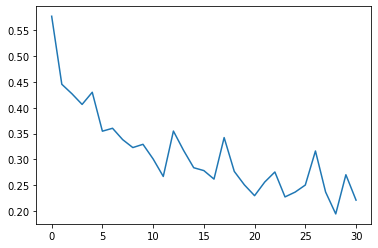

Epoch 1/100
8/8 - 9s - loss: 1.3322 - accuracy: 0.1186 - auc_1: 0.2806 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.1272 - val_loss: 1.0818 - val_accuracy: 0.3937 - val_auc_1: 0.6415 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.2491 - 9s/epoch - 1s/step
Epoch 2/100
8/8 - 1s - loss: 1.1542 - accuracy: 0.2806 - auc_1: 0.4608 - precision_1: 0.1071 - recall_1: 0.0119 - f1_score: 0.2566 - val_loss: 1.0139 - val_accuracy: 0.4409 - val_auc_1: 0.7446 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.2894 - 1s/epoch - 173ms/step
Epoch 3/100
8/8 - 1s - loss: 1.0708 - accuracy: 0.4506 - auc_1: 0.6536 - precision_1: 0.4211 - recall_1: 0.0632 - f1_score: 0.3670 - val_loss: 1.0003 - val_accuracy: 0.5197 - val_auc_1: 0.7694 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.3378 - 1s/epoch - 176ms/step
Epoch 4/100
8/8 - 1s - loss: 0.7565 - accuracy: 0.4150 - auc_1: 0.6719 - precision_1: 0.4691 - recall_1:

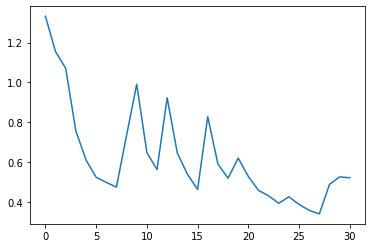

Epoch 1/100
8/8 - 8s - loss: 1.3414 - accuracy: 0.2638 - auc_2: 0.4630 - precision_2: 0.0606 - recall_2: 0.0079 - f1_score: 0.2365 - val_loss: 1.1051 - val_accuracy: 0.2381 - val_auc_2: 0.4691 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.1486 - 8s/epoch - 1s/step
Epoch 2/100
8/8 - 1s - loss: 0.9953 - accuracy: 0.4724 - auc_2: 0.6796 - precision_2: 0.3103 - recall_2: 0.0354 - f1_score: 0.3799 - val_loss: 1.1462 - val_accuracy: 0.1349 - val_auc_2: 0.3374 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.1012 - 1s/epoch - 170ms/step
Epoch 3/100
8/8 - 1s - loss: 0.6918 - accuracy: 0.5000 - auc_2: 0.7310 - precision_2: 0.4638 - recall_2: 0.1260 - f1_score: 0.4012 - val_loss: 0.9612 - val_accuracy: 0.4206 - val_auc_2: 0.7106 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.2240 - 1s/epoch - 176ms/step
Epoch 4/100
8/8 - 1s - loss: 0.6054 - accuracy: 0.6339 - auc_2: 0.8262 - precision_2: 0.6703 - recall_2: 0.4803 

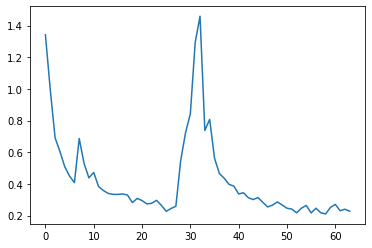

In [8]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    cnnlstm_intensity_body_model = CNNLSTM(n_features, n_length, n_outputs, multiclass=True)
    history = cnnlstm_intensity_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_intensity_body_model.save(model_path / 'body_intensity_cnnlstm.h5')

#### Training and Validation Line Plot

Text(0.5, 1.0, 'Unimodal Body CNN-BiLSTM')

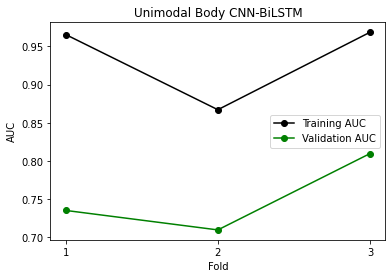

In [9]:
plt.plot(auc, label="Training AUC", marker="o", color="black")
plt.plot(auc_val, label="Validation AUC", marker="o", color="green")
plt.xticks(ticks=[0,1,2], labels=[1,2,3])
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.legend()
plt.title("Unimodal Body CNN-BiLSTM")

#### Training performance and variance

In [10]:
body_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_cnnlstm_train_results

{'Accuracy': 0.8012407620747884,
 'ROC/AUC': 0.9336355924606323,
 'Precision': 0.8033272822697958,
 'Recall': 0.7959706584612528,
 'F1-score': 0.6502104997634888}

In [11]:
body_cnnlstm_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
body_cnnlstm_train_var

{'Accuracy': 0.006003024666162402,
 'ROC/AUC': 0.0022224742124189825,
 'Precision': 0.00555461220591348,
 'Recall': 0.007213158944905571,
 'F1-score': 0.014732698253062892}

#### Validation performance

In [12]:
body_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
body_cnnlstm_val_results

{'Accuracy': 0.5054993132750193,
 'ROC/AUC': 0.7514067888259888,
 'Precision': 0.5065825084845225,
 'Recall': 0.5054993132750193,
 'F1-score': 0.2993583381175995}

In [13]:
body_cnnlstm_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
body_cnnlstm_val_var

{'Accuracy': 0.0057728601621417465,
 'ROC/AUC': 0.0018001531831851973,
 'Precision': 0.00556712394408285,
 'Recall': 0.0057728601621417465,
 'F1-score': 0.003921298100877972}

#### Predictions and performance on test set

In [14]:
cnnlstm_intensity_body_model = load_model(model_path / 'body_intensity_cnnlstm.h5')
y_pred = cnnlstm_intensity_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_intensity_body_model.evaluate(X_test, y_test)
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cnnlstm_auc.append(round(auc, 2))
cnnlstm_acc.append(round(acc * 100, 2))
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 2s 52ms/step - loss: 0.8640 - accuracy: 0.5277 - auc_2: 0.7514 - precision_2: 0.5419 - recall_2: 0.5234 - f1_score: 0.2949
Accuracy: 52.77% 
Balanced Accuracy: 30.30% 
ROC/AUC: 0.75 
Precision: 0.54 
Recall: 0.52 
F1 score: 0.29


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

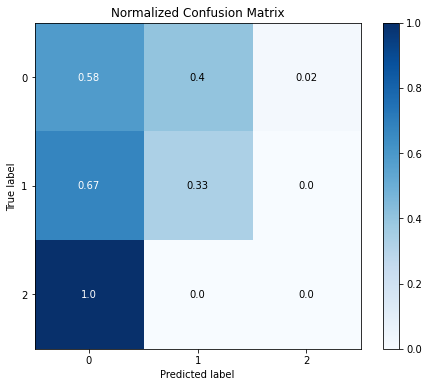

In [15]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

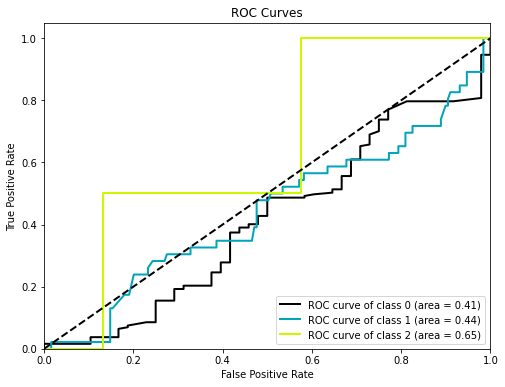

In [16]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

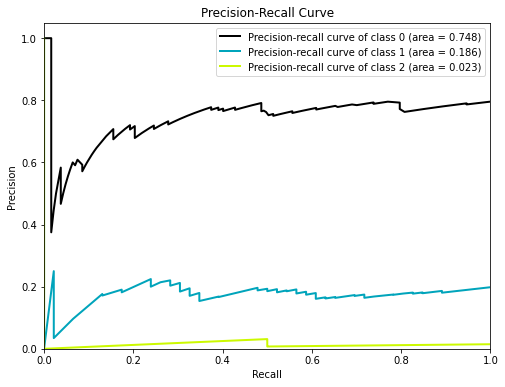

In [17]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, plot_micro=False, figsize=(8,6))

### 1.2 RCNN

Epoch 1/100
15/15 - 2s - loss: 3.9332 - accuracy: 0.6123 - auc_3: 0.8196 - precision_3: 0.6159 - recall_3: 0.5911 - f1_score: 0.2934 - val_loss: 0.6619 - val_accuracy: 0.7076 - val_auc_3: 0.8727 - val_precision_3: 0.7076 - val_recall_3: 0.7076 - val_f1_score: 0.2763 - 2s/epoch - 162ms/step
Epoch 2/100
15/15 - 0s - loss: 1.9304 - accuracy: 0.6547 - auc_3: 0.8539 - precision_3: 0.6496 - recall_3: 0.6165 - f1_score: 0.3111 - val_loss: 0.7433 - val_accuracy: 0.7076 - val_auc_3: 0.8803 - val_precision_3: 0.7076 - val_recall_3: 0.7076 - val_f1_score: 0.2763 - 417ms/epoch - 28ms/step
Epoch 3/100
15/15 - 0s - loss: 1.1510 - accuracy: 0.4153 - auc_3: 0.6272 - precision_3: 0.6190 - recall_3: 0.3030 - f1_score: 0.2399 - val_loss: 0.8753 - val_accuracy: 0.7076 - val_auc_3: 0.7802 - val_precision_3: 0.9524 - val_recall_3: 0.2542 - val_f1_score: 0.2763 - 420ms/epoch - 28ms/step
Epoch 4/100
15/15 - 0s - loss: 1.2375 - accuracy: 0.6292 - auc_3: 0.7679 - precision_3: 0.7397 - recall_3: 0.3792 - f1_scor

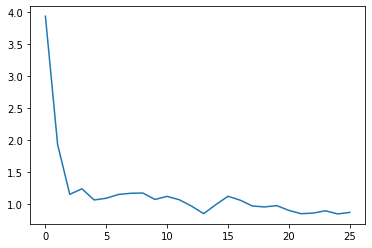

Epoch 1/100
15/15 - 2s - loss: 7.1984 - accuracy: 0.6356 - auc_4: 0.8256 - precision_4: 0.6452 - recall_4: 0.6165 - f1_score: 0.2996 - val_loss: 0.6331 - val_accuracy: 0.6780 - val_auc_4: 0.8638 - val_precision_4: 0.6780 - val_recall_4: 0.6780 - val_f1_score: 0.2694 - 2s/epoch - 163ms/step
Epoch 2/100
15/15 - 0s - loss: 2.7846 - accuracy: 0.6631 - auc_4: 0.8419 - precision_4: 0.6704 - recall_4: 0.6335 - f1_score: 0.2745 - val_loss: 0.9933 - val_accuracy: 0.6780 - val_auc_4: 0.7108 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.2694 - 440ms/epoch - 29ms/step
Epoch 3/100
15/15 - 0s - loss: 1.4949 - accuracy: 0.1441 - auc_4: 0.3947 - precision_4: 0.0701 - recall_4: 0.0466 - f1_score: 0.1113 - val_loss: 1.4448 - val_accuracy: 0.0042 - val_auc_4: 0.3773 - val_precision_4: 0.0042 - val_recall_4: 0.0042 - val_f1_score: 0.0028 - 429ms/epoch - 29ms/step
Epoch 4/100
15/15 - 0s - loss: 1.3914 - accuracy: 0.0953 - auc_4: 0.3797 - precision_4: 0.0570 - recall_4: 0.0381 -

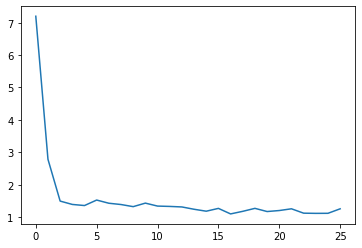

Epoch 1/100
15/15 - 3s - loss: 2.3547 - accuracy: 0.5233 - auc_5: 0.6773 - precision_5: 0.5430 - recall_5: 0.4682 - f1_score: 0.2634 - val_loss: 1.2991 - val_accuracy: 0.2119 - val_auc_5: 0.4652 - val_precision_5: 0.3357 - val_recall_5: 0.1992 - val_f1_score: 0.1695 - 3s/epoch - 174ms/step
Epoch 2/100
15/15 - 0s - loss: 1.1184 - accuracy: 0.5869 - auc_5: 0.7506 - precision_5: 0.6589 - recall_5: 0.4216 - f1_score: 0.2821 - val_loss: 0.9526 - val_accuracy: 0.5890 - val_auc_5: 0.7399 - val_precision_5: 0.9388 - val_recall_5: 0.1949 - val_f1_score: 0.3190 - 473ms/epoch - 32ms/step
Epoch 3/100
15/15 - 0s - loss: 1.1144 - accuracy: 0.5847 - auc_5: 0.7580 - precision_5: 0.6966 - recall_5: 0.4280 - f1_score: 0.2908 - val_loss: 1.3879 - val_accuracy: 0.2034 - val_auc_5: 0.4559 - val_precision_5: 0.2192 - val_recall_5: 0.2034 - val_f1_score: 0.1642 - 419ms/epoch - 28ms/step
Epoch 4/100
15/15 - 0s - loss: 0.9961 - accuracy: 0.5148 - auc_5: 0.6800 - precision_5: 0.5850 - recall_5: 0.3792 - f1_scor

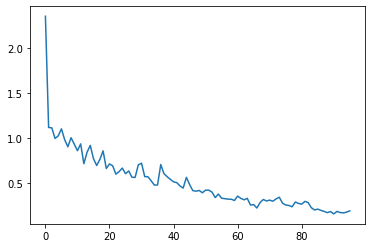

In [18]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    rcnn_intensity_body_model = RCNN(n_features, n_length, n_outputs, multiclass=True)
    history = rcnn_intensity_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_intensity_body_model.save(model_path / 'body_intensity_rcnn.h5')

#### Training and Validation Line Plot

Text(0.5, 1.0, 'Unimodal Body RCNN')

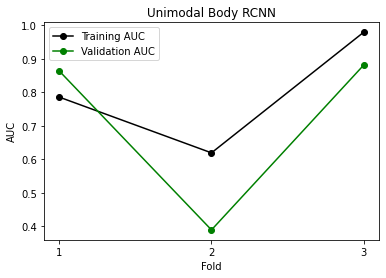

In [19]:
plt.plot(auc, label="Training AUC", marker="o", color="black")
plt.plot(auc_val, label="Validation AUC", marker="o", color="green")
plt.xticks(ticks=[0,1,2], labels=[1,2,3])
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.legend()
plt.title("Unimodal Body RCNN")

#### Training performance

In [20]:
body_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_rcnn_train_results

{'Accuracy': 0.665960450967153,
 'ROC/AUC': 0.7950417796770731,
 'Precision': 0.6911780635515848,
 'Recall': 0.548022598028183,
 'F1-score': 0.48926471670468646}

In [21]:
body_rcnn_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
body_rcnn_train_var

{'Accuracy': 0.03360604072755614,
 'ROC/AUC': 0.021637395548633576,
 'Precision': 0.031157192603085405,
 'Recall': 0.07305231888009267,
 'F1-score': 0.07096161489611456}

#### Validation performance

In [22]:
body_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
body_rcnn_val_results

{'Accuracy': 0.4872881546616554,
 'ROC/AUC': 0.7116264800230662,
 'Precision': 0.48337733714530867,
 'Recall': 0.46327684121206403,
 'F1-score': 0.3303208922346433}

In [23]:
body_rcnn_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
body_rcnn_val_var

{'Accuracy': 0.09739778700042016,
 'ROC/AUC': 0.051896998651244725,
 'Precision': 0.11194952731254411,
 'Recall': 0.10622347043460524,
 'F1-score': 0.05702526353190463}

#### Predictions and performance on test set

In [24]:
rcnn_intensity_body_model = load_model(model_path / 'body_intensity_rcnn.h5')
y_pred = rcnn_intensity_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_intensity_body_model.evaluate(X_test, y_test)
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
rcnn_auc.append(round(auc, 2))
rcnn_acc.append(round(acc * 100, 2))
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 0s 8ms/step - loss: 1.0493 - accuracy: 0.4298 - auc_5: 0.7137 - precision_5: 0.4372 - recall_5: 0.4298 - f1_score: 0.2412
Accuracy: 42.98% 
Balanced Accuracy: 24.01% 
ROC/AUC: 0.71 
Precision: 0.44 
Recall: 0.43 
F1 score: 0.24


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

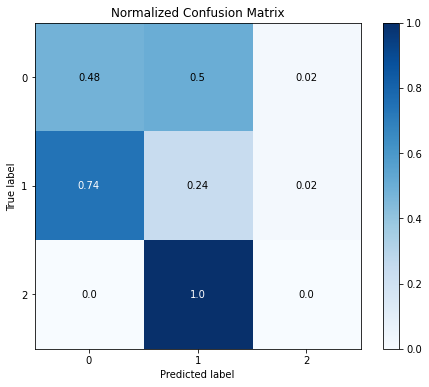

In [25]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

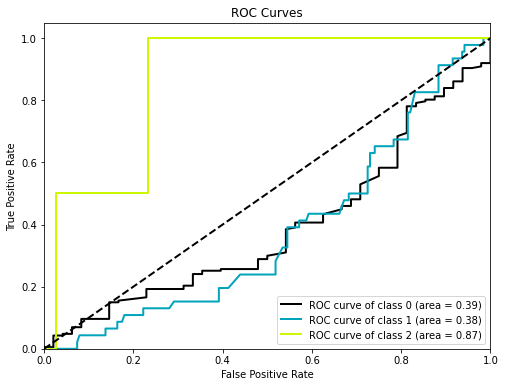

In [26]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

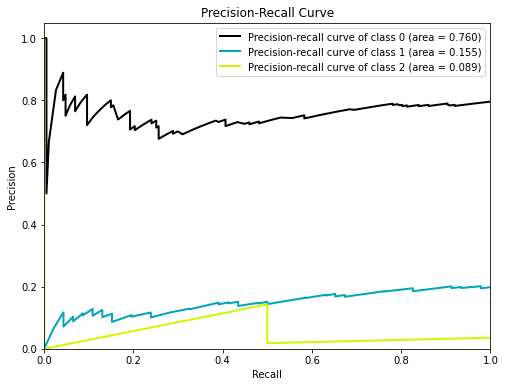

In [27]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, figsize=(8,6), plot_micro=False)

## 2. Unimodal Face (Facial Expression + Head Pose)

In [28]:
X_train, X_test, y_train, y_test = load_dataset('AUs', level=True, nopain=False)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(366, 1, 350, 25) (366, 3)
(231, 1, 350, 25) (231, 3)


In [29]:
extra_X_train, extra_X_test, extra_y_train, extra_y_test = load_dataset('AUs', level=True, nopain=False, only_minority=True)
jitter_X = jitter(extra_X_train, sigma=0.03)
reshaped_X = extra_X_train.reshape((extra_X_train.shape[0], extra_X_train.shape[2], extra_X_train.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))
augmented_X = np.concatenate((rotated_X, jitter_X), axis=0)
add_y = np.concatenate((extra_y_train, extra_y_train), axis=0)
full_X = np.concatenate((augmented_X, X), axis=0)
full_y = np.concatenate((add_y, y), axis=0)
full_X.shape

(682, 1, 350, 25)

In [30]:
classes = get_class_names('AUs', level=True, nopain=False)
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

Mild        211
Moderate    152
Severe        3
dtype: int64

In [31]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 0.5781990521327014, 1: 0.8026315789473685, 2: 40.666666666666664}

### 2.1 CNN + BiLSTM

Epoch 1/100
15/15 - 10s - loss: 1.3576 - accuracy: 0.5154 - auc_6: 0.6468 - precision_6: 0.6391 - recall_6: 0.2379 - f1_score: 0.2592 - val_loss: 1.0338 - val_accuracy: 0.4693 - val_auc_6: 0.6283 - val_precision_6: 0.7895 - val_recall_6: 0.1316 - val_f1_score: 0.2188 - 10s/epoch - 634ms/step
Epoch 2/100
15/15 - 3s - loss: 1.1349 - accuracy: 0.5308 - auc_6: 0.7030 - precision_6: 0.5731 - recall_6: 0.4405 - f1_score: 0.2703 - val_loss: 1.0246 - val_accuracy: 0.4386 - val_auc_6: 0.6681 - val_precision_6: 0.5082 - val_recall_6: 0.1360 - val_f1_score: 0.2123 - 3s/epoch - 174ms/step
Epoch 3/100
15/15 - 3s - loss: 0.9301 - accuracy: 0.5639 - auc_6: 0.7852 - precision_6: 0.6095 - recall_6: 0.5088 - f1_score: 0.3075 - val_loss: 1.0492 - val_accuracy: 0.4474 - val_auc_6: 0.6475 - val_precision_6: 0.4474 - val_recall_6: 0.1491 - val_f1_score: 0.2301 - 3s/epoch - 170ms/step
Epoch 4/100
15/15 - 3s - loss: 0.7999 - accuracy: 0.5903 - auc_6: 0.7932 - precision_6: 0.6080 - recall_6: 0.5330 - f1_score:

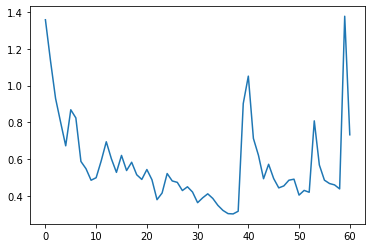

Epoch 1/100
15/15 - 9s - loss: 1.2905 - accuracy: 0.5231 - auc_7: 0.6646 - precision_7: 0.6419 - recall_7: 0.3033 - f1_score: 0.2521 - val_loss: 1.0081 - val_accuracy: 0.6167 - val_auc_7: 0.6906 - val_precision_7: 0.8667 - val_recall_7: 0.0573 - val_f1_score: 0.2866 - 9s/epoch - 627ms/step
Epoch 2/100
15/15 - 3s - loss: 1.0753 - accuracy: 0.5011 - auc_7: 0.6670 - precision_7: 0.5568 - recall_7: 0.3231 - f1_score: 0.2554 - val_loss: 1.0458 - val_accuracy: 0.4890 - val_auc_7: 0.6104 - val_precision_7: 0.5667 - val_recall_7: 0.0749 - val_f1_score: 0.2486 - 3s/epoch - 169ms/step
Epoch 3/100
15/15 - 3s - loss: 0.9578 - accuracy: 0.5077 - auc_7: 0.7254 - precision_7: 0.5437 - recall_7: 0.4242 - f1_score: 0.2618 - val_loss: 1.0039 - val_accuracy: 0.5022 - val_auc_7: 0.6698 - val_precision_7: 0.6667 - val_recall_7: 0.1233 - val_f1_score: 0.2565 - 3s/epoch - 173ms/step
Epoch 4/100
15/15 - 3s - loss: 0.8178 - accuracy: 0.5341 - auc_7: 0.7521 - precision_7: 0.5602 - recall_7: 0.4088 - f1_score: 0

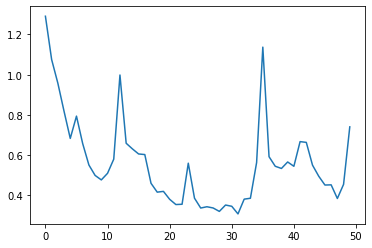

Epoch 1/100
15/15 - 9s - loss: 1.4168 - accuracy: 0.4571 - auc_8: 0.6611 - precision_8: 0.4741 - recall_8: 0.1209 - f1_score: 0.2210 - val_loss: 1.0567 - val_accuracy: 0.5022 - val_auc_8: 0.6545 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_f1_score: 0.2513 - 9s/epoch - 626ms/step
Epoch 2/100
15/15 - 3s - loss: 1.1022 - accuracy: 0.5538 - auc_8: 0.7579 - precision_8: 0.6109 - recall_8: 0.3934 - f1_score: 0.3210 - val_loss: 1.3762 - val_accuracy: 0.0264 - val_auc_8: 0.3869 - val_precision_8: 0.0159 - val_recall_8: 0.0132 - val_f1_score: 0.0212 - 3s/epoch - 172ms/step
Epoch 3/100
15/15 - 3s - loss: 0.9835 - accuracy: 0.4527 - auc_8: 0.6292 - precision_8: 0.4191 - recall_8: 0.2220 - f1_score: 0.3462 - val_loss: 1.1481 - val_accuracy: 0.2159 - val_auc_8: 0.4676 - val_precision_8: 0.1892 - val_recall_8: 0.0617 - val_f1_score: 0.1813 - 3s/epoch - 170ms/step
Epoch 4/100
15/15 - 3s - loss: 0.8615 - accuracy: 0.6000 - auc_8: 0.8039 - precision_8: 0.6490 - recall_8: 0.4835 - f1_

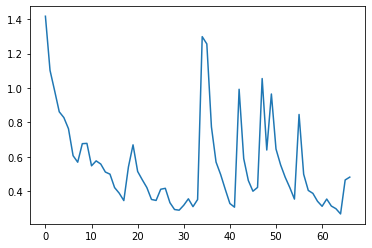

In [32]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    cnnlstm_intensity_face_model = CNNLSTM(n_features, n_length, n_outputs, multiclass=True)
    history = cnnlstm_intensity_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_intensity_face_model.save(model_path / 'face_intensity_cnnlstm.h5')

#### Training and Validation Line Plot

Text(0.5, 1.0, 'Unimodal Face CNN-BiLSTM')

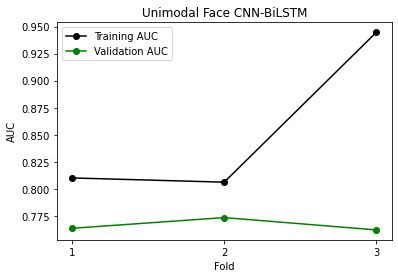

In [33]:
plt.plot(auc, label="Training AUC", marker="o", color="black")
plt.plot(auc_val, label="Validation AUC", marker="o", color="green")
plt.xticks(ticks=[0,1,2], labels=[1,2,3])
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.legend()
plt.title("Unimodal Face CNN-BiLSTM")

#### Training performance and variance

In [34]:
face_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
face_cnnlstm_train_results

{'Accuracy': 0.6920269330342611,
 'ROC/AUC': 0.8536316752433777,
 'Precision': 0.6993731260299683,
 'Recall': 0.6736828684806824,
 'F1-score': 0.5406612157821655}

In [35]:
face_cnnlstm_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
face_cnnlstm_train_var

{'Accuracy': 0.007484054505094977,
 'ROC/AUC': 0.004156749846525069,
 'Precision': 0.006928285933895495,
 'Recall': 0.009193284958477932,
 'F1-score': 0.006476940473059282}

#### Validation performance and variance

In [36]:
face_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
face_cnnlstm_val_results

{'Accuracy': 0.5704072912534078,
 'ROC/AUC': 0.7662280400594076,
 'Precision': 0.5739683111508688,
 'Recall': 0.5572236378987631,
 'F1-score': 0.4031623899936676}

In [37]:
face_cnnlstm_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
face_cnnlstm_val_var

{'Accuracy': 0.0008857331075502215,
 'ROC/AUC': 2.5568937593176437e-05,
 'Precision': 0.0007671446282376199,
 'Recall': 0.0008983231700041315,
 'F1-score': 0.003423792490994041}

#### Predictions and performance on test set

In [38]:
cnnlstm_intensity_face_model = load_model(model_path / 'face_intensity_cnnlstm.h5')
y_pred = cnnlstm_intensity_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_intensity_face_model.evaluate(X_test, y_test)
cnnlstm_auc.append(round(auc, 2))
cnnlstm_acc.append(round(acc * 100, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 2s 51ms/step - loss: 1.1442 - accuracy: 0.3636 - auc_7: 0.6565 - precision_7: 0.3545 - recall_7: 0.3377 - f1_score: 0.2510
Accuracy: 36.36% 
ROC/AUC: 0.66 
Precision: 0.35 
Recall: 0.34 
F1 score: 0.25


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

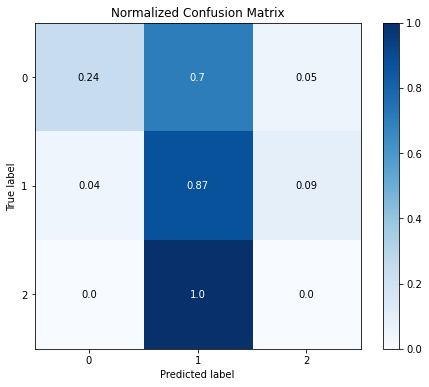

In [39]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

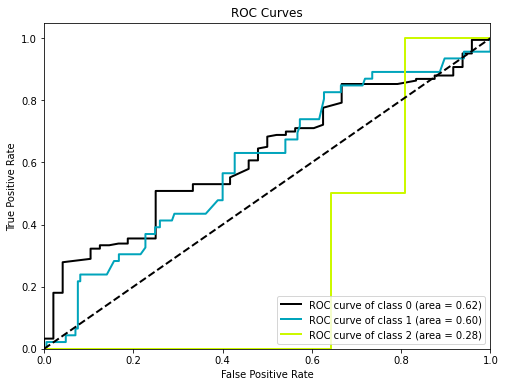

In [40]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

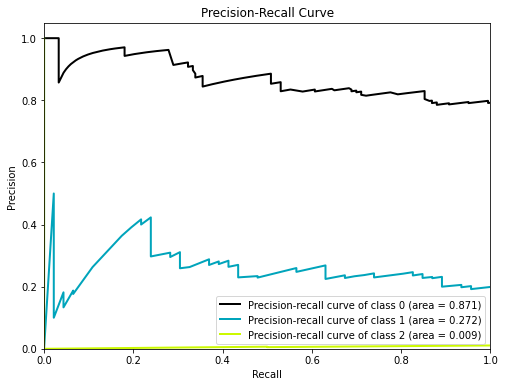

In [41]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, figsize=(8,6), plot_micro=False)

### 2.2 RCNN

Epoch 1/100
15/15 - 3s - loss: 4.8221 - accuracy: 0.6542 - auc_9: 0.8134 - precision_9: 0.6675 - recall_9: 0.6057 - f1_score: 0.3053 - val_loss: 0.8647 - val_accuracy: 0.6447 - val_auc_9: 0.7571 - val_precision_9: 0.6447 - val_recall_9: 0.6447 - val_f1_score: 0.2613 - 3s/epoch - 186ms/step
Epoch 2/100
15/15 - 0s - loss: 1.4840 - accuracy: 0.3590 - auc_9: 0.5758 - precision_9: 0.4559 - recall_9: 0.2048 - f1_score: 0.2263 - val_loss: 1.1274 - val_accuracy: 0.2675 - val_auc_9: 0.5284 - val_precision_9: 0.9697 - val_recall_9: 0.1404 - val_f1_score: 0.1954 - 412ms/epoch - 27ms/step
Epoch 3/100
15/15 - 0s - loss: 1.3445 - accuracy: 0.3084 - auc_9: 0.5311 - precision_9: 0.3333 - recall_9: 0.1784 - f1_score: 0.2042 - val_loss: 1.2793 - val_accuracy: 0.2675 - val_auc_9: 0.5303 - val_precision_9: 0.2748 - val_recall_9: 0.2675 - val_f1_score: 0.1954 - 419ms/epoch - 28ms/step
Epoch 4/100
15/15 - 0s - loss: 1.1561 - accuracy: 0.3326 - auc_9: 0.5548 - precision_9: 0.3506 - recall_9: 0.2379 - f1_scor

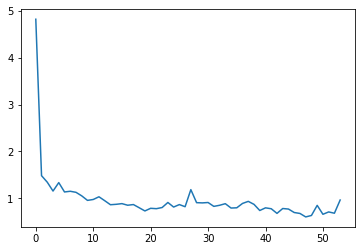

Epoch 1/100
15/15 - 2s - loss: 2.0606 - accuracy: 0.5736 - auc_10: 0.6728 - precision_10: 0.6010 - recall_10: 0.5495 - f1_score: 0.2820 - val_loss: 1.0200 - val_accuracy: 0.6652 - val_auc_10: 0.6974 - val_precision_10: 0.6652 - val_recall_10: 0.6652 - val_f1_score: 0.2663 - 2s/epoch - 159ms/step
Epoch 2/100
15/15 - 0s - loss: 1.2567 - accuracy: 0.4967 - auc_10: 0.6449 - precision_10: 0.6343 - recall_10: 0.3011 - f1_score: 0.2479 - val_loss: 0.9221 - val_accuracy: 0.6652 - val_auc_10: 0.7814 - val_precision_10: 0.9400 - val_recall_10: 0.2070 - val_f1_score: 0.2663 - 470ms/epoch - 31ms/step
Epoch 3/100
15/15 - 0s - loss: 1.2124 - accuracy: 0.5275 - auc_10: 0.6525 - precision_10: 0.6016 - recall_10: 0.3319 - f1_score: 0.2538 - val_loss: 1.0437 - val_accuracy: 0.6652 - val_auc_10: 0.6761 - val_precision_10: 0.6652 - val_recall_10: 0.6652 - val_f1_score: 0.2663 - 427ms/epoch - 28ms/step
Epoch 4/100
15/15 - 0s - loss: 1.2443 - accuracy: 0.4901 - auc_10: 0.6180 - precision_10: 0.5000 - recall

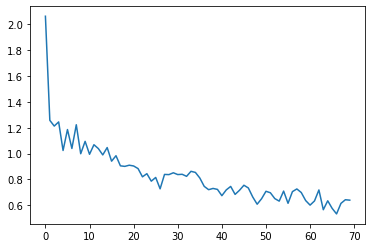

Epoch 1/100
15/15 - 2s - loss: 5.9981 - accuracy: 0.6396 - auc_11: 0.7974 - precision_11: 0.6443 - recall_11: 0.6132 - f1_score: 0.2900 - val_loss: 0.6787 - val_accuracy: 0.6960 - val_auc_11: 0.8788 - val_precision_11: 0.6960 - val_recall_11: 0.6960 - val_f1_score: 0.2736 - 2s/epoch - 156ms/step
Epoch 2/100
15/15 - 0s - loss: 2.4635 - accuracy: 0.6440 - auc_11: 0.8148 - precision_11: 0.6449 - recall_11: 0.6066 - f1_score: 0.2802 - val_loss: 0.8764 - val_accuracy: 0.6960 - val_auc_11: 0.8696 - val_precision_11: 0.6960 - val_recall_11: 0.6960 - val_f1_score: 0.2736 - 411ms/epoch - 27ms/step
Epoch 3/100
15/15 - 0s - loss: 1.3816 - accuracy: 0.2879 - auc_11: 0.4976 - precision_11: 0.2697 - recall_11: 0.0901 - f1_score: 0.1878 - val_loss: 1.2318 - val_accuracy: 0.0132 - val_auc_11: 0.3891 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00 - val_f1_score: 0.0087 - 412ms/epoch - 27ms/step
Epoch 4/100
15/15 - 0s - loss: 1.2587 - accuracy: 0.3560 - auc_11: 0.5276 - precision_11: 0.3483 

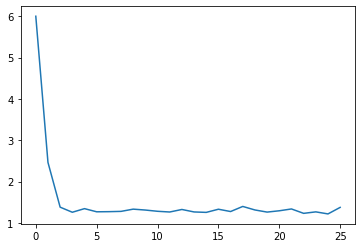

In [42]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    rcnn_intensity_face_model = RCNN(n_features, n_length, n_outputs, multiclass=True)
    history = rcnn_intensity_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_intensity_face_model.save(model_path / 'face_intensity_rcnn.h5')

#### Training and Validation Line Plot

Text(0.5, 1.0, 'Unimodal Face RCNN')

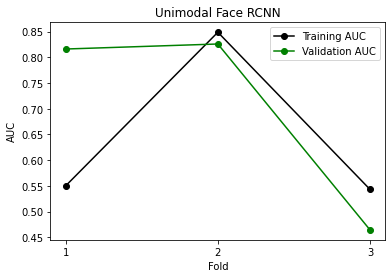

In [43]:
plt.plot(auc, label="Training AUC", marker="o", color="black")
plt.plot(auc_val, label="Validation AUC", marker="o", color="green")
plt.xticks(ticks=[0,1,2], labels=[1,2,3])
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.legend()
plt.title("Unimodal Face RCNN")

#### Training performance and variance

In [44]:
face_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
face_rcnn_train_results

{'Accuracy': 0.4427587191263835,
 'ROC/AUC': 0.6472607254981995,
 'Precision': 0.4391091763973236,
 'Recall': 0.31518453111251193,
 'F1-score': 0.2964579313993454}

In [45]:
face_rcnn_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
face_rcnn_train_var

{'Accuracy': 0.015352282284023943,
 'ROC/AUC': 0.02032070606178375,
 'Precision': 0.01975180661386311,
 'Recall': 0.04251081205480132,
 'F1-score': 0.005580205620605276}

#### Validation performance and variance

In [46]:
face_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
face_rcnn_val_results

{'Accuracy': 0.39845944102853537,
 'ROC/AUC': 0.7021233439445496,
 'Precision': 0.40243727651735145,
 'Recall': 0.3911237207551797,
 'F1-score': 0.22659094786892334}

In [47]:
face_rcnn_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
face_rcnn_val_var

{'Accuracy': 0.07645219365574908,
 'ROC/AUC': 0.028311663159804823,
 'Precision': 0.07499225775209319,
 'Recall': 0.07719592786903522,
 'F1-score': 0.026865709409832333}

#### Predictions and performance on test set

In [48]:
rcnn_intensity_face_model = load_model(model_path / 'face_intensity_rcnn.h5')
y_pred = rcnn_intensity_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_intensity_face_model.evaluate(X_test, y_test)
rcnn_auc.append(round(auc, 2))
rcnn_acc.append(round(acc * 100, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 0s 8ms/step - loss: 1.2399 - accuracy: 0.1991 - auc_10: 0.5742 - precision_10: 0.2018 - recall_10: 0.1991 - f1_score: 0.1111
Accuracy: 19.91% 
ROC/AUC: 0.57 
Precision: 0.20 
Recall: 0.20 
F1 score: 0.11


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

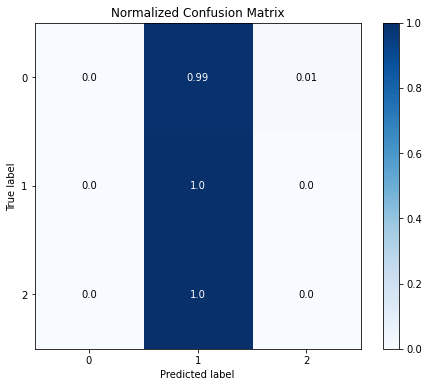

In [49]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

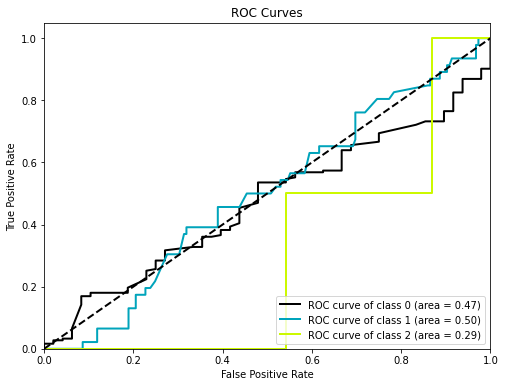

In [50]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

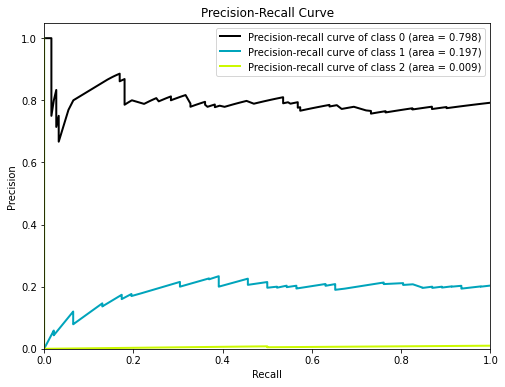

In [51]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, figsize=(8,6), plot_micro=False)

## 3. Multimodal Early Fusion

In [52]:
X_train, X_test, y_train, y_test = load_fusioned_dataset(level=True, nopain=False)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(366, 1, 350, 60) (366, 3)
(231, 1, 350, 60) (231, 3)


In [53]:
extra_X_train, extra_X_test, extra_y_train, extra_y_test = load_fusioned_dataset(level=True, nopain=False, only_minority=True)
jitter_X = jitter(extra_X_train, sigma=0.03)
reshaped_X = extra_X_train.reshape((extra_X_train.shape[0], extra_X_train.shape[2], extra_X_train.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))
augmented_X = np.concatenate((rotated_X, jitter_X), axis=0)
add_y = np.concatenate((extra_y_train, extra_y_train), axis=0)
full_X = np.concatenate((augmented_X, X), axis=0)
full_y = np.concatenate((add_y, y), axis=0)
full_X.shape

(682, 1, 350, 60)

### 3.1 CNN + BiLSTM

Epoch 1/100
15/15 - 9s - loss: 1.3960 - accuracy: 0.3744 - auc_12: 0.5467 - precision_12: 0.3636 - recall_12: 0.1233 - f1_score: 0.2436 - val_loss: 1.0302 - val_accuracy: 0.4605 - val_auc_12: 0.6326 - val_precision_12: 0.5893 - val_recall_12: 0.1447 - val_f1_score: 0.2262 - 9s/epoch - 631ms/step
Epoch 2/100
15/15 - 3s - loss: 0.9667 - accuracy: 0.5374 - auc_12: 0.7203 - precision_12: 0.5671 - recall_12: 0.4559 - f1_score: 0.2861 - val_loss: 0.9244 - val_accuracy: 0.5307 - val_auc_12: 0.7611 - val_precision_12: 0.5611 - val_recall_12: 0.4430 - val_f1_score: 0.2338 - 3s/epoch - 171ms/step
Epoch 3/100
15/15 - 3s - loss: 0.7975 - accuracy: 0.6366 - auc_12: 0.8197 - precision_12: 0.6598 - recall_12: 0.5683 - f1_score: 0.3573 - val_loss: 0.9480 - val_accuracy: 0.5307 - val_auc_12: 0.7127 - val_precision_12: 0.7156 - val_recall_12: 0.3421 - val_f1_score: 0.2550 - 3s/epoch - 169ms/step
Epoch 4/100
15/15 - 3s - loss: 0.5589 - accuracy: 0.6322 - auc_12: 0.8523 - precision_12: 0.6634 - recall_12:

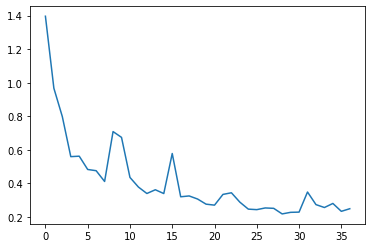

Epoch 1/100
15/15 - 9s - loss: 1.2883 - accuracy: 0.5407 - auc_13: 0.7163 - precision_13: 0.6971 - recall_13: 0.3187 - f1_score: 0.2511 - val_loss: 1.1468 - val_accuracy: 0.1454 - val_auc_13: 0.3998 - val_precision_13: 0.0714 - val_recall_13: 0.0044 - val_f1_score: 0.1180 - 9s/epoch - 615ms/step
Epoch 2/100
15/15 - 3s - loss: 0.9118 - accuracy: 0.4242 - auc_13: 0.6642 - precision_13: 0.4858 - recall_13: 0.2264 - f1_score: 0.2331 - val_loss: 1.0267 - val_accuracy: 0.3700 - val_auc_13: 0.6299 - val_precision_13: 0.6667 - val_recall_13: 0.1057 - val_f1_score: 0.2675 - 3s/epoch - 171ms/step
Epoch 3/100
15/15 - 3s - loss: 0.6511 - accuracy: 0.6286 - auc_13: 0.8384 - precision_13: 0.6991 - recall_13: 0.5209 - f1_score: 0.3775 - val_loss: 0.8713 - val_accuracy: 0.5374 - val_auc_13: 0.7857 - val_precision_13: 0.6667 - val_recall_13: 0.1322 - val_f1_score: 0.4019 - 3s/epoch - 173ms/step
Epoch 4/100
15/15 - 3s - loss: 0.6209 - accuracy: 0.6571 - auc_13: 0.8612 - precision_13: 0.7113 - recall_13:

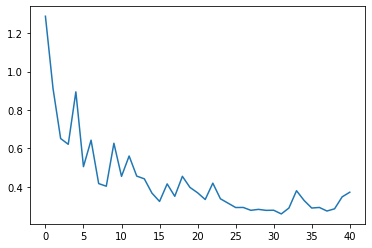

Epoch 1/100
15/15 - 9s - loss: 1.3459 - accuracy: 0.3868 - auc_14: 0.5535 - precision_14: 0.5351 - recall_14: 0.1341 - f1_score: 0.2227 - val_loss: 0.9501 - val_accuracy: 0.6432 - val_auc_14: 0.7225 - val_precision_14: 0.7959 - val_recall_14: 0.1718 - val_f1_score: 0.2616 - 9s/epoch - 627ms/step
Epoch 2/100
15/15 - 3s - loss: 1.0386 - accuracy: 0.5253 - auc_14: 0.7217 - precision_14: 0.5820 - recall_14: 0.3978 - f1_score: 0.2892 - val_loss: 0.9107 - val_accuracy: 0.6123 - val_auc_14: 0.8022 - val_precision_14: 0.6173 - val_recall_14: 0.2203 - val_f1_score: 0.2798 - 3s/epoch - 172ms/step
Epoch 3/100
15/15 - 3s - loss: 0.7960 - accuracy: 0.5846 - auc_14: 0.8030 - precision_14: 0.6355 - recall_14: 0.4637 - f1_score: 0.3494 - val_loss: 0.8519 - val_accuracy: 0.5991 - val_auc_14: 0.8065 - val_precision_14: 0.6299 - val_recall_14: 0.4273 - val_f1_score: 0.2926 - 3s/epoch - 172ms/step
Epoch 4/100
15/15 - 3s - loss: 0.5607 - accuracy: 0.6505 - auc_14: 0.8557 - precision_14: 0.6909 - recall_14:

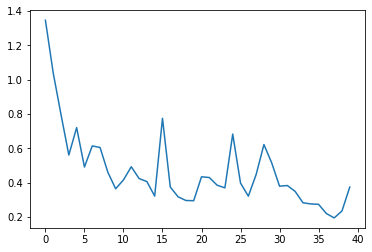

In [54]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    cnnlstm_intensity_earlyfusion_model = CNNLSTM(n_features, n_length, n_outputs, multiclass=True)
    history = cnnlstm_intensity_earlyfusion_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_intensity_earlyfusion_model.save(model_path / 'early_intensity_cnnlstm.h5')

#### Training and Validation Line Plot

Text(0.5, 1.0, 'Early Fusion CNN-BiLSTM')

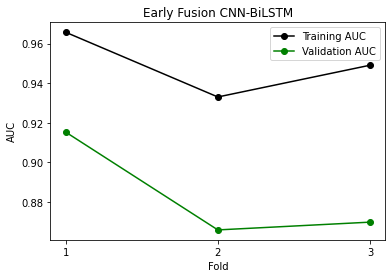

In [55]:
plt.plot(auc, label="Training AUC", marker="o", color="black")
plt.plot(auc_val, label="Validation AUC", marker="o", color="green")
plt.xticks(ticks=[0,1,2], labels=[1,2,3])
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.legend()
plt.title("Early Fusion CNN-BiLSTM")

#### Training performance and variance

In [56]:
early_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
early_cnnlstm_train_results

{'Accuracy': 0.8204063177108765,
 'ROC/AUC': 0.9493037660916647,
 'Precision': 0.8232627908388773,
 'Recall': 0.8196737170219421,
 'F1-score': 0.7067287365595499}

In [57]:
early_cnnlstm_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
early_cnnlstm_train_var

{'Accuracy': 0.0006249247354546128,
 'ROC/AUC': 0.000178428580460219,
 'Precision': 0.0005904710775257942,
 'Recall': 0.0006397963772712956,
 'F1-score': 0.004290883181985648}

#### Validation performance and variance

In [58]:
early_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
early_cnnlstm_val_results

{'Accuracy': 0.7257515986760458,
 'ROC/AUC': 0.8836482961972555,
 'Precision': 0.7295513153076172,
 'Recall': 0.7242831786473592,
 'F1-score': 0.5493855675061544}

In [59]:
early_cnnlstm_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
early_cnnlstm_val_var

{'Accuracy': 0.0010909813729927326,
 'ROC/AUC': 0.0005035178023181035,
 'Precision': 0.0009442062699799673,
 'Recall': 0.0010790651247237154,
 'F1-score': 0.00185254083660248}

#### Predictions and performance on test set

In [60]:
cnnlstm_intensity_earlyfusion_model = load_model(model_path / 'early_intensity_cnnlstm.h5')
y_pred = cnnlstm_intensity_earlyfusion_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_intensity_earlyfusion_model.evaluate(X_test, y_test)
cnnlstm_auc.append(round(auc, 2))
cnnlstm_acc.append(round(acc * 100, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 2s 53ms/step - loss: 1.0141 - accuracy: 0.3810 - auc_12: 0.6459 - precision_12: 0.3825 - recall_12: 0.3593 - f1_score: 0.2586
Accuracy: 38.10% 
ROC/AUC: 0.65 
Precision: 0.38 
Recall: 0.36 
F1 score: 0.26


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

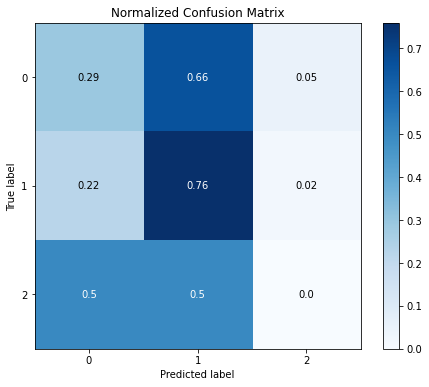

In [61]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

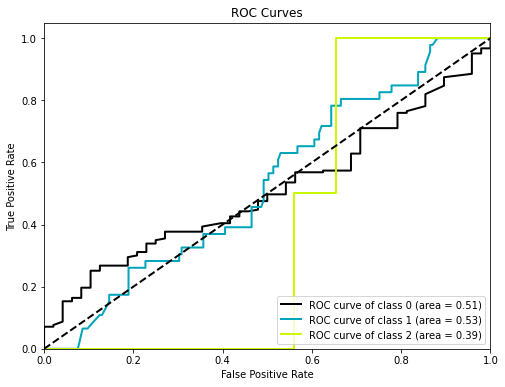

In [62]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

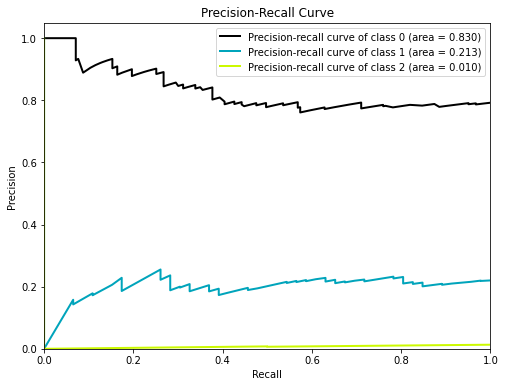

In [63]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, figsize=(8,6), plot_micro=False)

### 3.2 RCNN

Epoch 1/100
15/15 - 2s - loss: 5.9079 - accuracy: 0.6498 - auc_15: 0.8156 - precision_15: 0.6636 - recall_15: 0.6300 - f1_score: 0.2733 - val_loss: 0.6904 - val_accuracy: 0.6447 - val_auc_15: 0.8375 - val_precision_15: 0.6447 - val_recall_15: 0.6447 - val_f1_score: 0.2613 - 2s/epoch - 162ms/step
Epoch 2/100
15/15 - 0s - loss: 2.7242 - accuracy: 0.6850 - auc_15: 0.8367 - precision_15: 0.6867 - recall_15: 0.6806 - f1_score: 0.2802 - val_loss: 0.7935 - val_accuracy: 0.6447 - val_auc_15: 0.8453 - val_precision_15: 0.6447 - val_recall_15: 0.6447 - val_f1_score: 0.2613 - 409ms/epoch - 27ms/step
Epoch 3/100
15/15 - 0s - loss: 1.6305 - accuracy: 0.6696 - auc_15: 0.7643 - precision_15: 0.6730 - recall_15: 0.5441 - f1_score: 0.2684 - val_loss: 1.0565 - val_accuracy: 0.6447 - val_auc_15: 0.7109 - val_precision_15: 1.0000 - val_recall_15: 0.1535 - val_f1_score: 0.2613 - 422ms/epoch - 28ms/step
Epoch 4/100
15/15 - 0s - loss: 1.3858 - accuracy: 0.2952 - auc_15: 0.4868 - precision_15: 0.2194 - recall

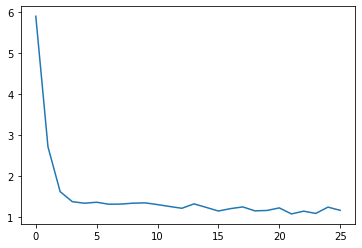

Epoch 1/100
15/15 - 2s - loss: 4.3308 - accuracy: 0.6308 - auc_16: 0.8128 - precision_16: 0.6448 - recall_16: 0.6264 - f1_score: 0.2778 - val_loss: 0.6957 - val_accuracy: 0.6652 - val_auc_16: 0.8521 - val_precision_16: 0.6652 - val_recall_16: 0.6652 - val_f1_score: 0.2663 - 2s/epoch - 164ms/step
Epoch 2/100
15/15 - 0s - loss: 2.1639 - accuracy: 0.6659 - auc_16: 0.8551 - precision_16: 0.6674 - recall_16: 0.6659 - f1_score: 0.2665 - val_loss: 0.7872 - val_accuracy: 0.6652 - val_auc_16: 0.8562 - val_precision_16: 0.6652 - val_recall_16: 0.6652 - val_f1_score: 0.2663 - 425ms/epoch - 28ms/step
Epoch 3/100
15/15 - 0s - loss: 1.2553 - accuracy: 0.6022 - auc_16: 0.7417 - precision_16: 0.6759 - recall_16: 0.4813 - f1_score: 0.2644 - val_loss: 1.1676 - val_accuracy: 0.0176 - val_auc_16: 0.3845 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00 - val_f1_score: 0.0115 - 421ms/epoch - 28ms/step
Epoch 4/100
15/15 - 0s - loss: 1.2525 - accuracy: 0.3385 - auc_16: 0.5174 - precision_16: 0.2920 

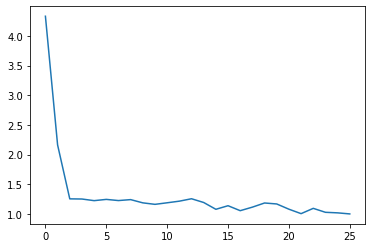

Epoch 1/100
15/15 - 2s - loss: 2.4066 - accuracy: 0.5604 - auc_17: 0.7529 - precision_17: 0.5833 - recall_17: 0.4769 - f1_score: 0.2989 - val_loss: 0.9541 - val_accuracy: 0.6960 - val_auc_17: 0.7423 - val_precision_17: 0.9773 - val_recall_17: 0.1894 - val_f1_score: 0.2736 - 2s/epoch - 166ms/step
Epoch 2/100
15/15 - 0s - loss: 1.2608 - accuracy: 0.3802 - auc_17: 0.5654 - precision_17: 0.3778 - recall_17: 0.2242 - f1_score: 0.2392 - val_loss: 1.0098 - val_accuracy: 0.6696 - val_auc_17: 0.7221 - val_precision_17: 0.6780 - val_recall_17: 0.5286 - val_f1_score: 0.2674 - 433ms/epoch - 29ms/step
Epoch 3/100
15/15 - 0s - loss: 1.1167 - accuracy: 0.5429 - auc_17: 0.7054 - precision_17: 0.6682 - recall_17: 0.3143 - f1_score: 0.2881 - val_loss: 1.0887 - val_accuracy: 0.1410 - val_auc_17: 0.4841 - val_precision_17: 0.7879 - val_recall_17: 0.1145 - val_f1_score: 0.1119 - 429ms/epoch - 29ms/step
Epoch 4/100
15/15 - 0s - loss: 1.1126 - accuracy: 0.4835 - auc_17: 0.6361 - precision_17: 0.5595 - recall

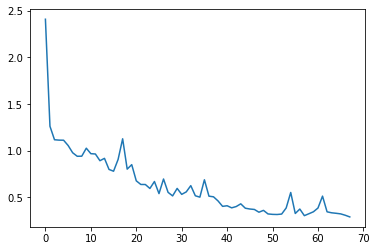

In [64]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    rcnn_intensity_earlyfusion_model = RCNN(n_features, n_length, n_outputs, multiclass=True)
    history = rcnn_intensity_earlyfusion_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_intensity_earlyfusion_model.save(model_path / 'early_intensity_rcnn.h5')

#### Training and Validation Line Plot

Text(0.5, 1.0, 'Early Fusion RCNN')

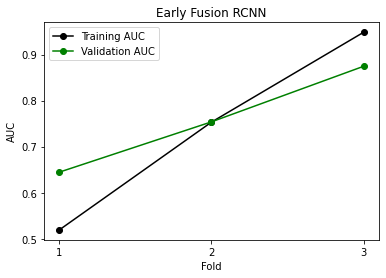

In [65]:
plt.plot(auc, label="Training AUC", marker="o", color="black")
plt.plot(auc_val, label="Validation AUC", marker="o", color="green")
plt.xticks(ticks=[0,1,2], labels=[1,2,3])
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.legend()
plt.title("Early Fusion RCNN")

#### Training performance and variance

In [66]:
early_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
early_rcnn_train_results

{'Accuracy': 0.5768230458100637,
 'ROC/AUC': 0.7402522365252177,
 'Precision': 0.5937931736310323,
 'Recall': 0.45211632053057355,
 'F1-score': 0.42565011481444043}

In [67]:
early_rcnn_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
early_rcnn_train_var

{'Accuracy': 0.034749435706068456,
 'ROC/AUC': 0.03079217643029687,
 'Precision': 0.04516410127877495,
 'Recall': 0.07754793764229383,
 'F1-score': 0.06684285639373168}

#### Validation performance and variance

In [68]:
early_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
early_rcnn_val_results

{'Accuracy': 0.6218151847521464,
 'ROC/AUC': 0.7576233545939127,
 'Precision': 0.6963087121645609,
 'Recall': 0.4705863445997238,
 'F1-score': 0.41528867681821185}

In [69]:
early_rcnn_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
early_rcnn_val_var

{'Accuracy': 0.0030902827482685146,
 'ROC/AUC': 0.00882037155758613,
 'Precision': 0.022427615983863645,
 'Recall': 0.03038631018725117,
 'F1-score': 0.018039923845690434}

#### Predictions and performance on test set

In [70]:
rcnn_intensity_earlyfusion_model = load_model(model_path / 'early_intensity_rcnn.h5')
y_pred = rcnn_intensity_earlyfusion_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_intensity_earlyfusion_model.evaluate(X_test, y_test)
rcnn_auc.append(round(auc, 2))
rcnn_acc.append(round(acc * 100, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 0s 9ms/step - loss: 0.9147 - accuracy: 0.3420 - auc_17: 0.6539 - precision_17: 0.3348 - recall_17: 0.3203 - f1_score: 0.2351
Accuracy: 34.20% 
ROC/AUC: 0.65 
Precision: 0.33 
Recall: 0.32 
F1 score: 0.24


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

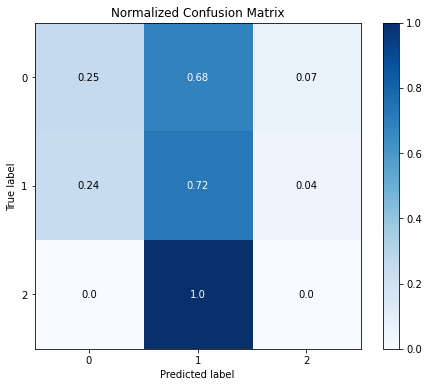

In [71]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

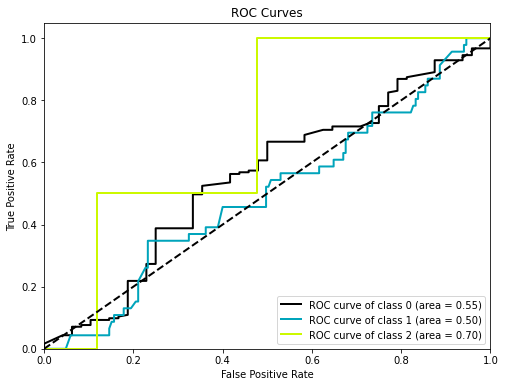

In [72]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

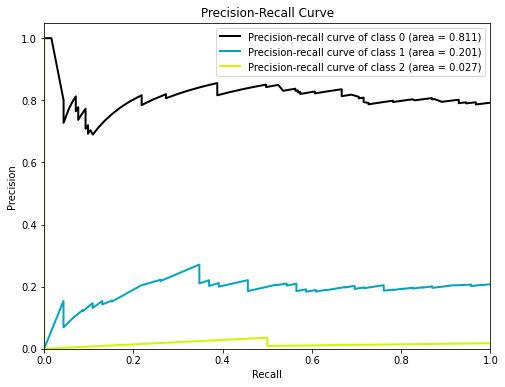

In [73]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, figsize=(8,6), plot_micro=False)

## 4. Multimodal Late Fusion

In [74]:
body_X_train, body_X_test, body_y_train, body_y_test = load_dataset('skeleton', level=True, fusion=True, nopain=False)
body_X = body_X_train.copy()
body_y = body_y_train.copy()

print(body_X_train.shape, body_y_train.shape)
print(body_X_test.shape, body_y_test.shape)

(366, 1, 350, 35) (366, 3)
(231, 1, 350, 35) (231, 3)


In [75]:
extra_body_X_train, extra_body_X_test, extra_body_y_train, extra_body_y_test = load_dataset('skeleton', level=True, nopain=False, only_minority=True, fusion=True)
jitter_X = jitter(extra_body_X_train, sigma=0.03)
reshaped_X = extra_body_X_train.reshape((extra_body_X_train.shape[0], extra_body_X_train.shape[2], extra_body_X_train.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))
augmented_X = np.concatenate((rotated_X, jitter_X), axis=0)
add_y = np.concatenate((extra_body_y_train, extra_body_y_train), axis=0)
full_body_X = np.concatenate((augmented_X, body_X), axis=0)
full_y = np.concatenate((add_y, body_y), axis=0)
full_body_X.shape

(682, 1, 350, 35)

In [76]:
face_X_train, face_X_test, face_y_train, face_y_test = load_dataset('AUs', level=True, nopain=False)
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

(366, 1, 350, 25) (366, 3)
(231, 1, 350, 25) (231, 3)


In [77]:
extra_face_X_train, extra_face_X_test, extra_face_y_train, extra_face_y_test = load_dataset('AUs', level=True, nopain=False, only_minority=True)
jitter_X = jitter(extra_face_X_train, sigma=0.03)
reshaped_X = extra_face_X_train.reshape((extra_face_X_train.shape[0], extra_face_X_train.shape[2], extra_face_X_train.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))
augmented_X = np.concatenate((rotated_X, jitter_X), axis=0)
add_y = np.concatenate((extra_face_y_train, extra_face_y_train), axis=0)
full_face_X = np.concatenate((augmented_X, face_X), axis=0)
full_face_X.shape

(682, 1, 350, 25)

In [78]:
n_length, body_features, face_features, n_outputs = face_X_train.shape[2], body_X_train.shape[-1], face_X_train.shape[-1], body_y_train.shape[1]

### 4.1 CNN + BiLSTM (Concatenation)

Epoch 1/100
15/15 - 18s - loss: 1.6566 - accuracy: 0.5881 - auc_18: 0.7405 - precision_18: 0.6566 - recall_18: 0.4295 - f1_score: 0.2731 - val_loss: 1.1103 - val_accuracy: 0.3246 - val_auc_18: 0.5092 - val_precision_18: 0.2308 - val_recall_18: 0.0132 - val_f1_score: 0.1876 - 18s/epoch - 1s/step
Epoch 2/100
15/15 - 5s - loss: 1.0330 - accuracy: 0.5088 - auc_18: 0.6835 - precision_18: 0.5314 - recall_18: 0.3546 - f1_score: 0.2703 - val_loss: 0.9919 - val_accuracy: 0.4781 - val_auc_18: 0.6889 - val_precision_18: 0.6600 - val_recall_18: 0.1447 - val_f1_score: 0.2215 - 5s/epoch - 342ms/step
Epoch 3/100
15/15 - 5s - loss: 0.8600 - accuracy: 0.6101 - auc_18: 0.7986 - precision_18: 0.6657 - recall_18: 0.4912 - f1_score: 0.3280 - val_loss: 0.9050 - val_accuracy: 0.5746 - val_auc_18: 0.7661 - val_precision_18: 0.8769 - val_recall_18: 0.2500 - val_f1_score: 0.2488 - 5s/epoch - 343ms/step
Epoch 4/100
15/15 - 5s - loss: 0.6916 - accuracy: 0.6740 - auc_18: 0.8637 - precision_18: 0.7211 - recall_18: 

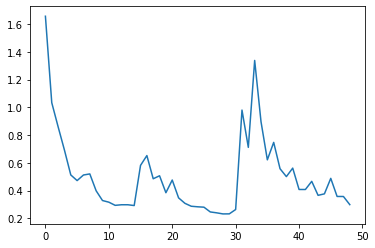

Epoch 1/100
15/15 - 18s - loss: 1.6233 - accuracy: 0.6637 - auc_19: 0.8391 - precision_19: 0.7222 - recall_19: 0.4286 - f1_score: 0.3207 - val_loss: 0.9367 - val_accuracy: 0.6652 - val_auc_19: 0.8659 - val_precision_19: 0.9000 - val_recall_19: 0.0793 - val_f1_score: 0.2663 - 18s/epoch - 1s/step
Epoch 2/100
15/15 - 5s - loss: 0.9927 - accuracy: 0.5516 - auc_19: 0.7339 - precision_19: 0.6988 - recall_19: 0.3824 - f1_score: 0.2766 - val_loss: 0.8877 - val_accuracy: 0.6696 - val_auc_19: 0.8675 - val_precision_19: 0.9375 - val_recall_19: 0.1322 - val_f1_score: 0.4004 - 5s/epoch - 345ms/step
Epoch 3/100
15/15 - 5s - loss: 0.8193 - accuracy: 0.5868 - auc_19: 0.7909 - precision_19: 0.7057 - recall_19: 0.4374 - f1_score: 0.3181 - val_loss: 0.8054 - val_accuracy: 0.6828 - val_auc_19: 0.8694 - val_precision_19: 0.9245 - val_recall_19: 0.2159 - val_f1_score: 0.3328 - 5s/epoch - 348ms/step
Epoch 4/100
15/15 - 5s - loss: 0.6212 - accuracy: 0.6923 - auc_19: 0.8842 - precision_19: 0.7350 - recall_19: 

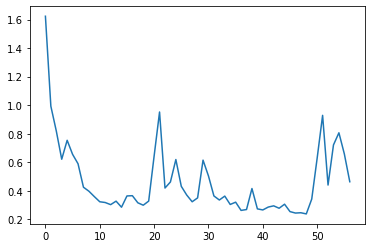

Epoch 1/100
15/15 - 17s - loss: 1.7245 - accuracy: 0.5560 - auc_20: 0.7532 - precision_20: 0.6588 - recall_20: 0.3055 - f1_score: 0.2967 - val_loss: 1.0479 - val_accuracy: 0.5374 - val_auc_20: 0.6531 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_f1_score: 0.2632 - 17s/epoch - 1s/step
Epoch 2/100
15/15 - 5s - loss: 1.0366 - accuracy: 0.4330 - auc_20: 0.6694 - precision_20: 0.4157 - recall_20: 0.2440 - f1_score: 0.2429 - val_loss: 1.0317 - val_accuracy: 0.4890 - val_auc_20: 0.6429 - val_precision_20: 0.5172 - val_recall_20: 0.0661 - val_f1_score: 0.2556 - 5s/epoch - 355ms/step
Epoch 3/100
15/15 - 5s - loss: 0.9068 - accuracy: 0.5670 - auc_20: 0.7624 - precision_20: 0.6423 - recall_20: 0.3868 - f1_score: 0.3321 - val_loss: 1.1108 - val_accuracy: 0.2291 - val_auc_20: 0.5079 - val_precision_20: 0.4118 - val_recall_20: 0.1233 - val_f1_score: 0.1673 - 5s/epoch - 348ms/step
Epoch 4/100
15/15 - 5s - loss: 0.6429 - accuracy: 0.6835 - auc_20: 0.8641 - precision_20: 0.7335 - rec

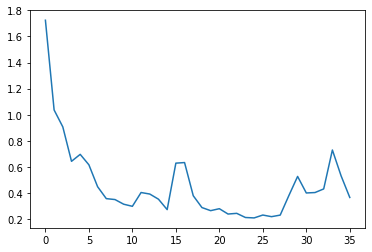

In [79]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(full_body_X):
    body_X_train, body_X_val = full_body_X[train_index], full_body_X[val_index]
    face_X_train, face_X_val = full_face_X[train_index], full_face_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    cnnlstm_intensity_latefusion_model = CNNLSTM_fusioned(body_features, face_features, n_length, n_outputs, multiclass=True)
    history = cnnlstm_intensity_latefusion_model.train(body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_intensity_latefusion_model.save(model_path / 'late_intensity_cnnlstm.h5')

#### Training and Validation Line Plot

Text(0.5, 1.0, 'Late Fusion CNN-BiLSTM')

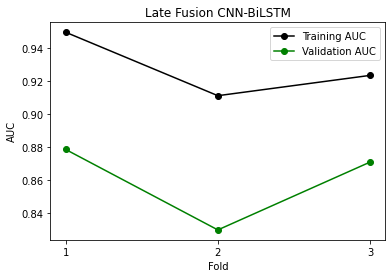

In [80]:
plt.plot(auc, label="Training AUC", marker="o", color="black")
plt.plot(auc_val, label="Validation AUC", marker="o", color="green")
plt.xticks(ticks=[0,1,2], labels=[1,2,3])
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.legend()
plt.title("Late Fusion CNN-BiLSTM")

#### Training performance and variance

In [81]:
late_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
late_cnnlstm_train_results

{'Accuracy': 0.7903600136439005,
 'ROC/AUC': 0.9281266927719116,
 'Precision': 0.8036758502324423,
 'Recall': 0.7815671960512797,
 'F1-score': 0.6449751655260721}

In [82]:
late_cnnlstm_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
late_cnnlstm_train_var

{'Accuracy': 0.0013062546049158958,
 'ROC/AUC': 0.0002581577545015534,
 'Precision': 0.0012255776637941393,
 'Recall': 0.0016684220660568233,
 'F1-score': 0.006395518063795989}

#### Validation performance and variance

In [83]:
late_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
late_cnnlstm_val_results

{'Accuracy': 0.6656297445297241,
 'ROC/AUC': 0.859676202138265,
 'Precision': 0.6686923702557882,
 'Recall': 0.6480343739191691,
 'F1-score': 0.48832719524701435}

In [84]:
late_cnnlstm_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
late_cnnlstm_val_var

{'Accuracy': 0.000849663884553801,
 'ROC/AUC': 0.0004603484286802326,
 'Precision': 0.0007826944998099192,
 'Recall': 0.0009035030376512371,
 'F1-score': 6.225827934041522e-05}

#### Performance and predictions on test set

In [85]:
cnnlstm_intensity_latefusion_model = load_model(model_path / 'late_intensity_cnnlstm.h5')
y_pred = cnnlstm_intensity_latefusion_model.predict([body_X_test, face_X_test])
_, acc, auc, precision, recall, f1 = cnnlstm_intensity_latefusion_model.evaluate([body_X_test, face_X_test], y_test)
cnnlstm_auc.append(round(auc, 2))
cnnlstm_acc.append(round(acc * 100, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 3s 109ms/step - loss: 1.0593 - accuracy: 0.4156 - auc_18: 0.7007 - precision_18: 0.4141 - recall_18: 0.4069 - f1_score: 0.2689
Accuracy: 41.56% 
ROC/AUC: 0.70 
Precision: 0.41 
Recall: 0.41 
F1 score: 0.27


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

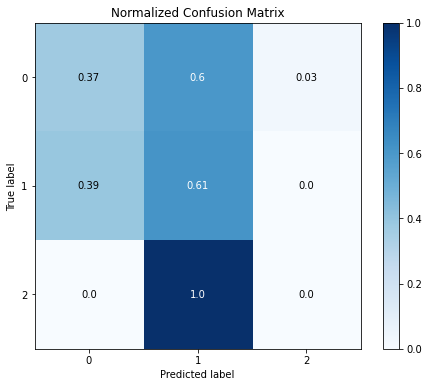

In [86]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

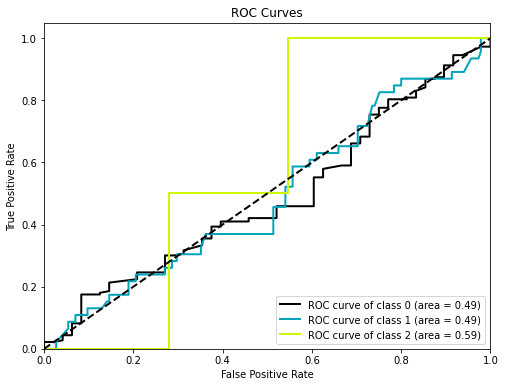

In [87]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

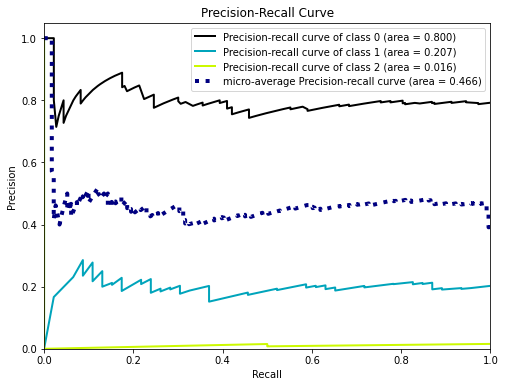

In [88]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, figsize=(8,6), plot_micro=False)

### 4.2 RCNN (Concatenation)

Epoch 1/100
15/15 - 3s - loss: 2.7280 - accuracy: 0.4185 - auc_21: 0.6077 - precision_21: 0.4349 - recall_21: 0.3458 - f1_score: 0.2871 - val_loss: 3.7035 - val_accuracy: 0.0088 - val_auc_21: 0.3259 - val_precision_21: 0.0088 - val_recall_21: 0.0088 - val_f1_score: 0.0058 - 3s/epoch - 176ms/step
Epoch 2/100
15/15 - 0s - loss: 4.6268 - accuracy: 0.2511 - auc_21: 0.4255 - precision_21: 0.2415 - recall_21: 0.2181 - f1_score: 0.2301 - val_loss: 1.8173 - val_accuracy: 0.5307 - val_auc_21: 0.6948 - val_precision_21: 0.5307 - val_recall_21: 0.5307 - val_f1_score: 0.2311 - 496ms/epoch - 33ms/step
Epoch 3/100
15/15 - 0s - loss: 2.6163 - accuracy: 0.5507 - auc_21: 0.7127 - precision_21: 0.5528 - recall_21: 0.5308 - f1_score: 0.3562 - val_loss: 1.7502 - val_accuracy: 0.6447 - val_auc_21: 0.8206 - val_precision_21: 0.6447 - val_recall_21: 0.6447 - val_f1_score: 0.2613 - 482ms/epoch - 32ms/step
Epoch 4/100
15/15 - 1s - loss: 1.4581 - accuracy: 0.5088 - auc_21: 0.7128 - precision_21: 0.5238 - recall

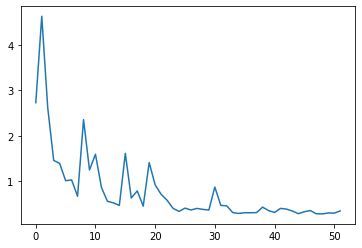

Epoch 1/100
15/15 - 3s - loss: 3.0818 - accuracy: 0.3780 - auc_22: 0.5622 - precision_22: 0.3839 - recall_22: 0.3560 - f1_score: 0.2423 - val_loss: 1.2053 - val_accuracy: 0.5595 - val_auc_22: 0.6852 - val_precision_22: 0.5670 - val_recall_22: 0.5595 - val_f1_score: 0.2398 - 3s/epoch - 172ms/step
Epoch 2/100
15/15 - 0s - loss: 1.5013 - accuracy: 0.5165 - auc_22: 0.6937 - precision_22: 0.5244 - recall_22: 0.4484 - f1_score: 0.3524 - val_loss: 2.2342 - val_accuracy: 0.3084 - val_auc_22: 0.5077 - val_precision_22: 0.3063 - val_recall_22: 0.2996 - val_f1_score: 0.1948 - 460ms/epoch - 31ms/step
Epoch 3/100
15/15 - 0s - loss: 1.2330 - accuracy: 0.5209 - auc_22: 0.7257 - precision_22: 0.5359 - recall_22: 0.4923 - f1_score: 0.3614 - val_loss: 0.8843 - val_accuracy: 0.6652 - val_auc_22: 0.8709 - val_precision_22: 0.6652 - val_recall_22: 0.6652 - val_f1_score: 0.2663 - 478ms/epoch - 32ms/step
Epoch 4/100
15/15 - 0s - loss: 0.9424 - accuracy: 0.5780 - auc_22: 0.7707 - precision_22: 0.5919 - recall

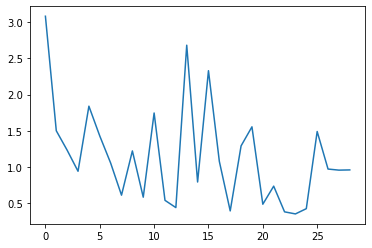

Epoch 1/100
15/15 - 3s - loss: 3.7408 - accuracy: 0.3670 - auc_23: 0.5480 - precision_23: 0.3621 - recall_23: 0.3231 - f1_score: 0.2468 - val_loss: 0.8351 - val_accuracy: 0.6960 - val_auc_23: 0.8084 - val_precision_23: 0.6960 - val_recall_23: 0.6960 - val_f1_score: 0.2736 - 3s/epoch - 167ms/step
Epoch 2/100
15/15 - 0s - loss: 2.9504 - accuracy: 0.4747 - auc_23: 0.6366 - precision_23: 0.4837 - recall_23: 0.4571 - f1_score: 0.3174 - val_loss: 7.2543 - val_accuracy: 0.0132 - val_auc_23: 0.2600 - val_precision_23: 0.0132 - val_recall_23: 0.0132 - val_f1_score: 0.0087 - 438ms/epoch - 29ms/step
Epoch 3/100
15/15 - 0s - loss: 2.4919 - accuracy: 0.3758 - auc_23: 0.5572 - precision_23: 0.3866 - recall_23: 0.3560 - f1_score: 0.2954 - val_loss: 1.3069 - val_accuracy: 0.5815 - val_auc_23: 0.7804 - val_precision_23: 0.5796 - val_recall_23: 0.5771 - val_f1_score: 0.2458 - 432ms/epoch - 29ms/step
Epoch 4/100
15/15 - 0s - loss: 2.7403 - accuracy: 0.4220 - auc_23: 0.6032 - precision_23: 0.4271 - recall

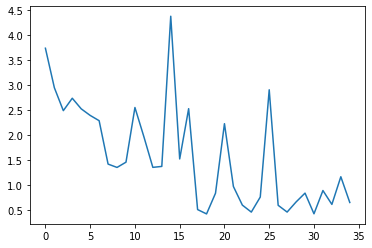

In [89]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(full_body_X):
    body_X_train, body_X_val = full_body_X[train_index], full_body_X[val_index]
    face_X_train, face_X_val = full_face_X[train_index], full_face_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    rcnn_intensity_latefusion_model = RCNN_fusioned(body_features, face_features, n_length, n_outputs, multiclass=True)
    history = rcnn_intensity_latefusion_model.train(body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_intensity_latefusion_model.save(model_path / 'late_intensity_rcnn.h5')

#### Training and Validation Line Plot

Text(0.5, 1.0, 'Late Fusion RCNN')

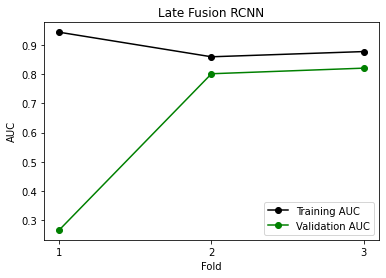

In [90]:
plt.plot(auc, label="Training AUC", marker="o", color="black")
plt.plot(auc_val, label="Validation AUC", marker="o", color="green")
plt.xticks(ticks=[0,1,2], labels=[1,2,3])
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.legend()
plt.title("Late Fusion RCNN")

#### Training performance and variance

In [91]:
late_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
late_rcnn_train_results

{'Accuracy': 0.7463862299919128,
 'ROC/AUC': 0.8939193288485209,
 'Precision': 0.7475217382113138,
 'Recall': 0.7317342162132263,
 'F1-score': 0.6033310890197754}

In [92]:
late_rcnn_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
late_rcnn_train_var

{'Accuracy': 0.002687061309394778,
 'ROC/AUC': 0.0013117722236333721,
 'Precision': 0.0028294248362507168,
 'Recall': 0.0037865995229608984,
 'F1-score': 0.012400274145117388}

#### Validation performance and variance

In [93]:
late_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
late_rcnn_val_results

{'Accuracy': 0.39936755038797855,
 'ROC/AUC': 0.6295579175154368,
 'Precision': 0.3996144328266382,
 'Recall': 0.3978991104910771,
 'F1-score': 0.2737128722170989}

In [94]:
late_rcnn_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
late_rcnn_val_var

{'Accuracy': 0.07147952424269349,
 'ROC/AUC': 0.06614162451000184,
 'Precision': 0.07138970789691451,
 'Recall': 0.07072899962913344,
 'F1-score': 0.028946713064035068}

#### Predictions and performance on test set

In [95]:
rcnn_intensity_latefusion_model = load_model(model_path / 'late_intensity_rcnn.h5')
y_pred = rcnn_intensity_latefusion_model.predict([body_X_test, face_X_test])
_, acc, auc, precision, recall, f1 = rcnn_intensity_latefusion_model.evaluate([body_X_test, face_X_test], y_test)
rcnn_auc.append(round(auc, 2))
rcnn_acc.append(round(acc * 100, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 0s 9ms/step - loss: 1.1552 - accuracy: 0.2294 - auc_23: 0.5797 - precision_23: 0.2170 - recall_23: 0.1991 - f1_score: 0.1386
Accuracy: 22.94% 
ROC/AUC: 0.58 
Precision: 0.22 
Recall: 0.20 
F1 score: 0.14


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

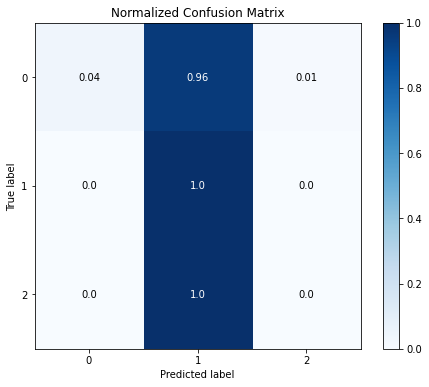

In [96]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

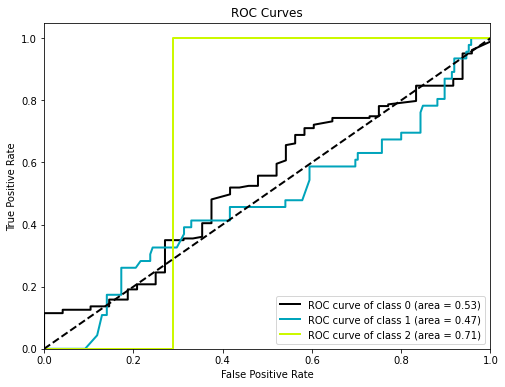

In [97]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

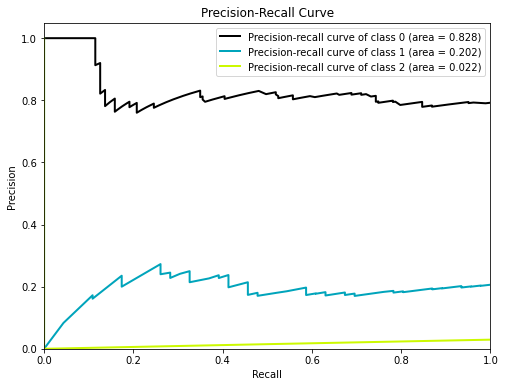

In [98]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, figsize=(8,6), plot_micro=False)

### 4.3 Ensemble

In [99]:
cnnlstm_body_member = KerasMember(name="CNN + Bidirectional LSTM Body Model", keras_model=cnnlstm_intensity_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
rcnn_body_member = KerasMember(name="RCNN Body Model", keras_model=rcnn_intensity_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
cnnlstm_face_member = KerasMember(name="CNN + Bidirectional LSTM Face Model", keras_model=cnnlstm_intensity_face_model, train_batches=(face_X_train, y_train), val_batches=(face_X_test, face_y_test))
rcnn_face_member = KerasMember(name="RCNN Face Model", keras_model=rcnn_intensity_face_model, train_batches=(face_X_train, y_train), val_batches=(face_X_test, face_y_test))

In [100]:
dirichletEnsemble = DirichletEnsemble()
dirichletEnsemble.add_member(cnnlstm_body_member)
dirichletEnsemble.add_member(rcnn_body_member)
dirichletEnsemble.add_member(cnnlstm_face_member)
dirichletEnsemble.add_member(rcnn_face_member)
dirichletEnsemble.fit()

In [101]:
e = dirichletEnsemble.describe()

CNN + Bidirectional LSTM Body Model (weight: 0.0037)
RCNN Body Model (weight: 0.1301)
CNN + Bidirectional LSTM Face Model (weight: 0.8544)
RCNN Face Model (weight: 0.0117)
Accuracy: 53.68% - ROC/AUC: 0.61 - Precision: 0.40 - Recall: 0.38 - F1 score: 0.30


## Results

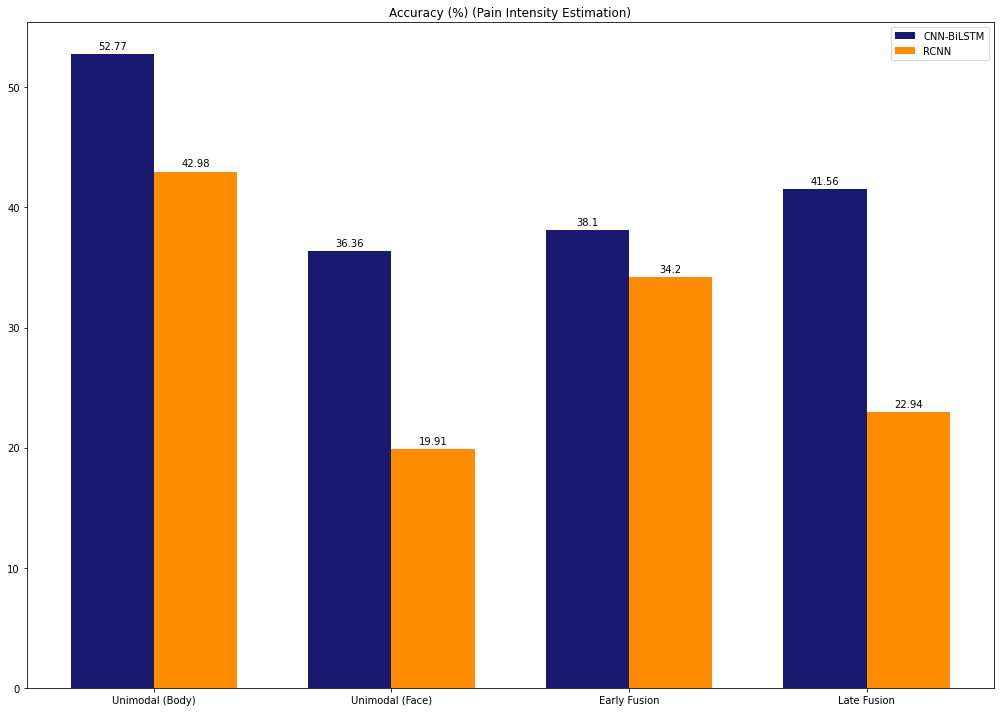

In [106]:
labels = ['Unimodal (Body)', 'Unimodal (Face)', 'Early Fusion', 'Late Fusion']

x = np.arange(len(labels)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(14, 10))
rects1 = ax.bar(x - width/2, cnnlstm_acc, width, label='CNN-BiLSTM', color='midnightblue')
rects2 = ax.bar(x + width/2, rcnn_acc, width, label='RCNN', color='darkorange')

ax.set_title('Accuracy (%) (Pain Intensity Estimation)')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

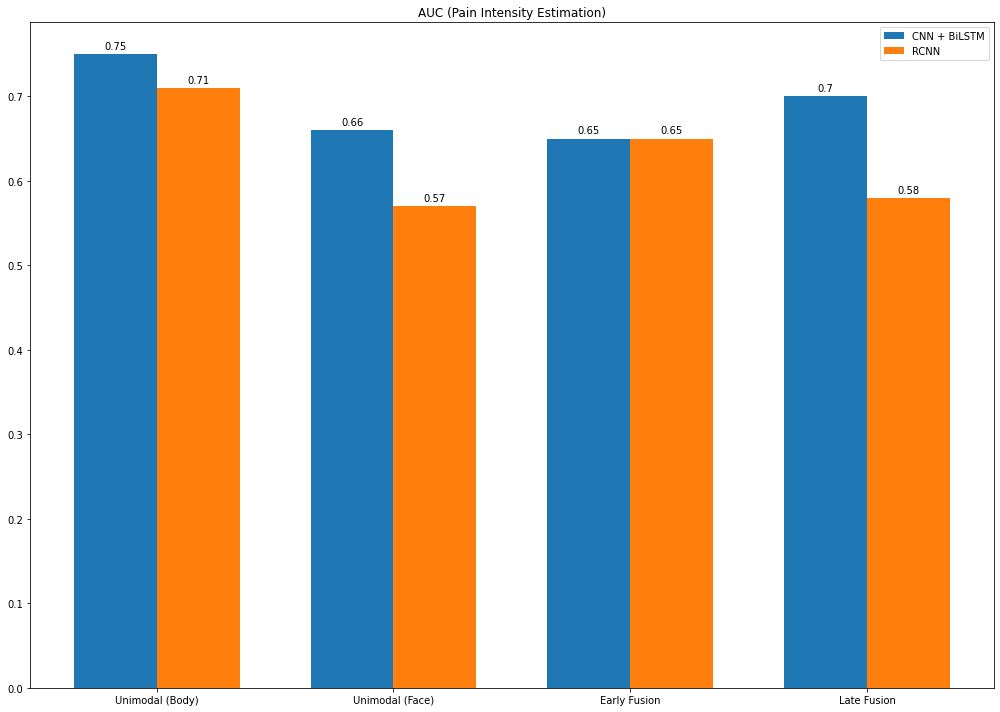

In [107]:
labels = ['Unimodal (Body)', 'Unimodal (Face)', 'Early Fusion', 'Late Fusion']

x = np.arange(len(labels)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(14, 10))
rects1 = ax.bar(x - width/2, cnnlstm_auc, width, label='CNN + BiLSTM')
rects2 = ax.bar(x + width/2, rcnn_auc, width, label='RCNN')

ax.set_title('AUC (Pain Intensity Estimation)')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()